In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor, ExactGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }
                }
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                }}
appliances = ["Refrigerator"]

In [5]:

def dataset_loader(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_delta= []
    x_train_timestamp = []
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    scaler_delta = StandardScaler()
    # train
    torch.set_default_dtype(torch.float64)
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
        

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."
        x = torch.tensor([0])
        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x1 = df["main"].values
        x = torch.cat((x,torch.tensor(x1)))
        x = abs(np.diff(np.array(x)))
        y = df[appliances[0]].values
    
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_train.extend(torch.tensor(x1))
        x_train_delta.extend(torch.tensor(x))
        y_train.extend(torch.tensor(y))
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = torch.tensor(x_train).reshape(-1, 1)
    y_train = torch.tensor(y_train).reshape(-1, 1)
    x_train_delta = torch.tensor(x_train_delta).reshape(-1,1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)
    x_train_delta = scaler_delta.fit_transform(x_train_delta)



    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    x_test_delta = []
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."
        x = torch.tensor([0])
        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x1 = df["main"].values
        x = torch.cat((x,torch.tensor(x1)))
        x = abs(np.diff(np.array(x)))
        y = df[appliances[0]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_test.extend(torch.tensor(x1))
        x_test_delta.extend(torch.tensor(x))
        y_test.extend(torch.tensor(y))
        x_test_timestamp.extend(timestamp)

    x_test = torch.tensor(x_test).reshape(-1, 1)
    y_test = torch.tensor(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)
    x_test_delta = torch.tensor(x_test_delta).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
    x_test_delta = scaler_delta.transform(x_test_delta)
    

    x_train = torch.tensor(x_train).reshape(x_train.shape[0], 1).to(torch.float64)
    y_train = torch.tensor(y_train).reshape(-1,).to(torch.float64)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1).to(torch.float64)
    x_train_delta = torch.tensor(x_train_delta).reshape(x_train_delta.shape[0], 1).to(torch.float64)
    x_test = torch.tensor(x_test).reshape(x_test.shape[0], 1).to(torch.float64)
    y_test = torch.tensor(y_test).reshape(-1,).to(torch.float64)
    x_test_delta = torch.tensor(x_test_delta).reshape(x_test_delta.shape[0], 1).to(torch.float64)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)


    return x_train, y_train, x_test, y_test, x_train_delta, x_test_delta, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time, scaler_delta


In [6]:
x_train, y_train, x_test, y_test, x_train_delta, x_test_delta, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time, scaler_delta = dataset_loader(appliances, train, test)

/tmp/ipykernel_1893326/3308341630.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).reshape(-1,).to(torch.float64)


In [7]:
x_train_delta.shape, x_test_delta.shape

(torch.Size([53456, 1]), torch.Size([16781, 1]))

In [8]:
print(x_train.shape, y_train.shape, x_train_timestamp.shape, x_test.shape, y_test.shape, x_test_timestamp.shape)

torch.Size([53456, 1]) torch.Size([53456]) torch.Size([53456, 1]) torch.Size([16781, 1]) torch.Size([16781]) torch.Size([16781, 1])


Text(0.5, 0, 'Timestamp Train')

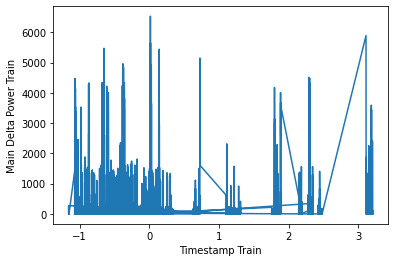

In [9]:
plt.plot(x_train_timestamp, scaler_delta.inverse_transform(x_train_delta.reshape(-1,1)))
plt.ylabel(f"Main Delta Power Train")
plt.xlabel(f"Timestamp Train")

Text(0.5, 0, 'Timestamp Test')

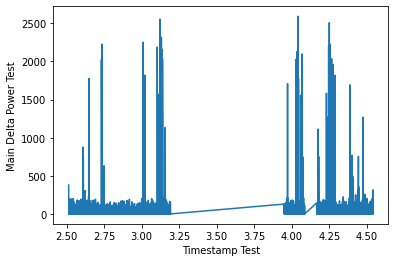

In [10]:
plt.plot(x_test_timestamp, scaler_delta.inverse_transform(x_test_delta.reshape(-1,1)))
plt.ylabel(f"Main Delta Power Test")
plt.xlabel(f"Timestamp Test")

Text(0.5, 0, 'Timestamp Train')

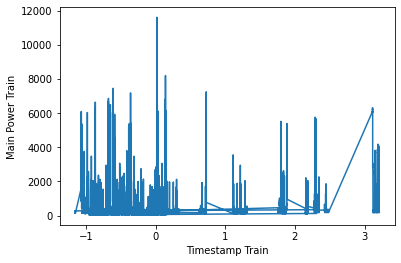

In [11]:
plt.plot(x_train_timestamp, scaler_x.inverse_transform(x_train.reshape(-1,1)))
plt.ylabel(f"Main Power Train")
plt.xlabel(f"Timestamp Train")

Text(0.5, 0, 'Timestamp Train')

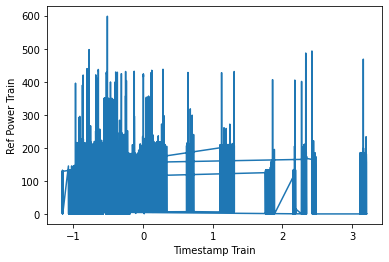

In [12]:
plt.plot(x_train_timestamp, scaler_y.inverse_transform(y_train.reshape(-1,1)))
plt.ylabel(f"Ref Power Train")
plt.xlabel(f"Timestamp Train")

Text(0.5, 0, 'Timestamp of Building 6')

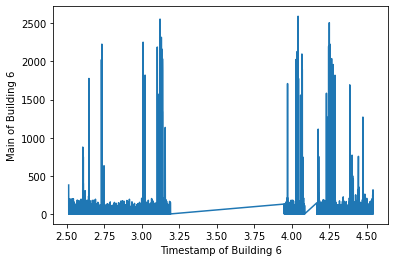

In [13]:
plt.plot(x_test_timestamp, scaler_x.inverse_transform(x_test.reshape(-1,1)))

plt.ylabel(f"Main of Building {6}")
plt.xlabel(f"Timestamp of Building {6}")
# plt.savefig(f"Building_{6}")

Text(0.5, 0, 'Timestamp test')

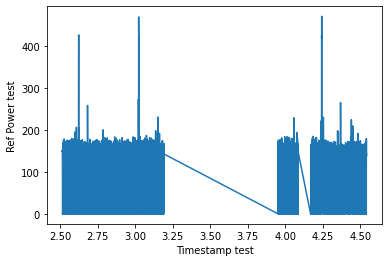

In [14]:
plt.plot(x_test_timestamp, y_test)
plt.ylabel(f"Ref Power test")
plt.xlabel(f"Timestamp test")

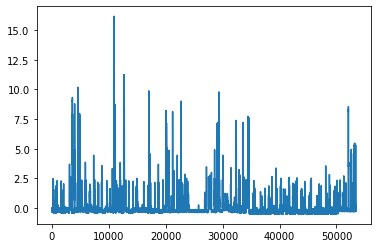

In [15]:
plt.plot(x_train)

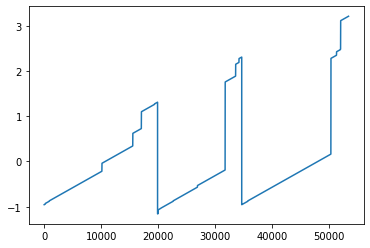

In [16]:
plt.plot(x_train_timestamp)

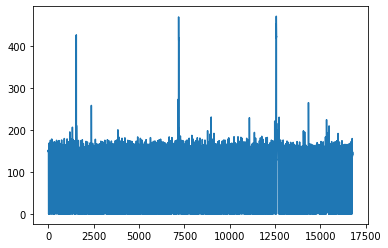

In [17]:
plt.plot(y_test)

Text(0, 0.5, 'Fridge Train Power')

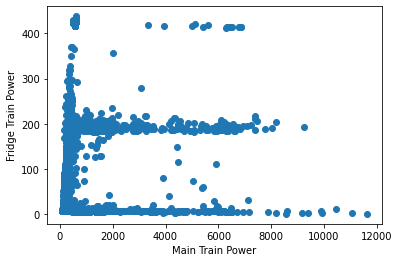

In [18]:
plt.scatter( scaler_x.inverse_transform(x_train[:19000]), scaler_y.inverse_transform(y_train[:19000].reshape(-1,1)))
plt.xlabel("Main Train Power")
plt.ylabel("Fridge Train Power")

Text(0, 0.5, 'Fridge test Power')

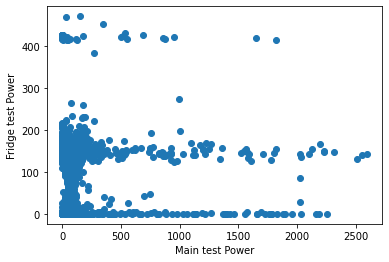

In [19]:
plt.scatter( scaler_x.inverse_transform(x_test),y_test.reshape(-1,1))
plt.xlabel("Main test Power")
plt.ylabel("Fridge test Power")

In [8]:
x_train_full = torch.cat((x_train, x_train_delta ,x_train_timestamp), dim=1)
x_test_full = torch.cat((x_test, x_test_delta, x_test_timestamp), dim=1)
x_train_full.shape, x_test_full.shape

(torch.Size([53456, 2]), torch.Size([16781, 2]))

In [9]:
x_train_full.dtype, x_test_full.dtype, y_train.dtype

(torch.float64, torch.float64, torch.float64)

Text(0, 0.5, 'Train Power')

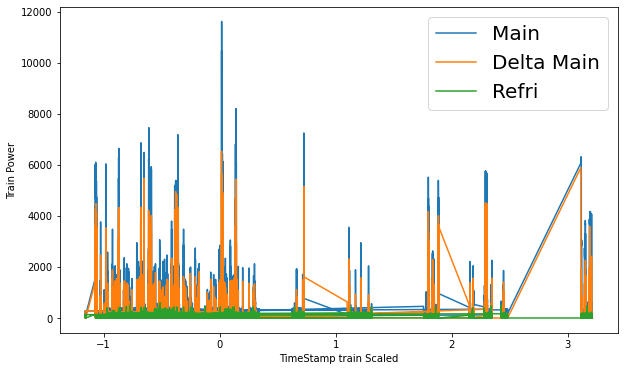

In [12]:
idx = 600
start = 52000
plt.figure(figsize=(10,6))
plt.plot(x_train_timestamp ,scaler_x.inverse_transform(x_train.cpu().reshape(-1,1)), label = "Main")
plt.plot(x_train_timestamp ,scaler_delta.inverse_transform(x_train_delta.cpu().reshape(-1,1)), label = "Delta Main")
plt.plot(x_train_timestamp ,scaler_y.inverse_transform(y_train.cpu().reshape(-1,1)), label = "Refri")
# plt.plot(x_test_timestamp[:idx], y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp train Scaled")
plt.ylabel("Train Power")

Text(0, 0.5, 'Test Power')

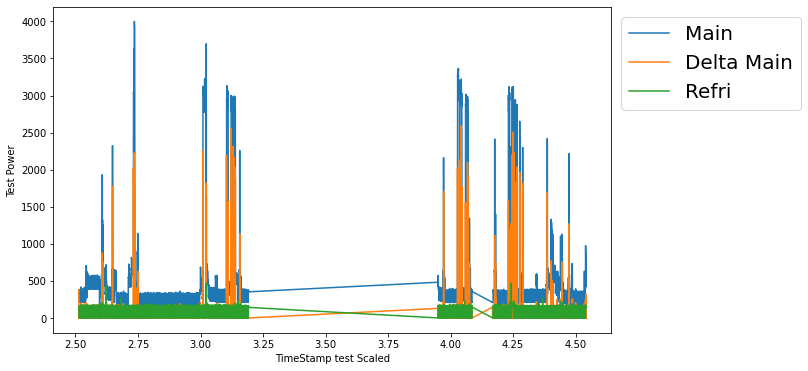

In [13]:
idx = 600
start = 52000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp ,scaler_x.inverse_transform(x_test.cpu().reshape(-1,1)), label = "Main")
plt.plot(x_test_timestamp ,scaler_delta.inverse_transform(x_test_delta.cpu().reshape(-1,1)), label = "Delta Main")
plt.plot(x_test_timestamp ,(y_test.cpu().reshape(-1,1)), label = "Refri")
# plt.plot(x_test_timestamp[:idx], y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Test Power")

### SGPR

/tmp/ipykernel_1893326/3759719034.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_trans = torch.tensor(torch.tensor(scaler_x.transform(y_test.reshape(-1,1))).reshape(-1,)).contiguous().to(torch.float64)


restart: 0, epoch: 1, iter: 1, loss: 1.4240
restart: 0, epoch: 2, iter: 1, loss: 1.4223
restart: 0, epoch: 3, iter: 1, loss: 1.4211


/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


restart: 0, epoch: 4, iter: 1, loss: 1.4205
restart: 0, epoch: 5, iter: 1, loss: 1.4205
restart: 0, epoch: 6, iter: 1, loss: 1.4202
restart: 0, epoch: 7, iter: 1, loss: 1.4198
restart: 0, epoch: 8, iter: 1, loss: 1.4195
restart: 0, epoch: 9, iter: 1, loss: 1.4194
restart: 0, epoch: 10, iter: 1, loss: 1.4192
restart: 0, epoch: 11, iter: 1, loss: 1.4189
restart: 0, epoch: 12, iter: 1, loss: 1.4187
restart: 0, epoch: 13, iter: 1, loss: 1.4185
restart: 0, epoch: 14, iter: 1, loss: 1.4184
restart: 0, epoch: 15, iter: 1, loss: 1.4182
restart: 0, epoch: 16, iter: 1, loss: 1.4180
restart: 0, epoch: 17, iter: 1, loss: 1.4178
restart: 0, epoch: 18, iter: 1, loss: 1.4176
restart: 0, epoch: 19, iter: 1, loss: 1.4175
restart: 0, epoch: 20, iter: 1, loss: 1.4173
restart: 0, epoch: 21, iter: 1, loss: 1.4172
restart: 0, epoch: 22, iter: 1, loss: 1.4170
restart: 0, epoch: 23, iter: 1, loss: 1.4168
restart: 0, epoch: 24, iter: 1, loss: 1.4167
restart: 0, epoch: 25, iter: 1, loss: 1.4166
restart: 0, epoc

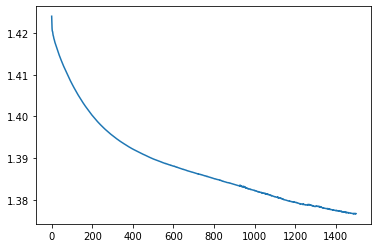

In [10]:
mae_arr =[]
rms_arr = []
y_pred_arr = []

batch = 512

# x_train = x_train[:4500]
# y_train = y_train[:4500]
# {'likelihood.noise_covar.noise': torch.tensor(0.01),
# 'base_covar_module.kernels.0.base_kernel.lengthscale': torch.tensor(0.5),
#         'base_covar_module.kernels.0.outputscale': torch.tensor(5.0),
#         'base_covar_module.kernels.1.kernels.0.outputscale':torch.tensor(1.0),
#         'base_covar_module.kernels.1.kernels.0.base_kernel.lengthscale': torch.tensor(0.1),
#         'base_covar_module.kernels.1.kernels.1.outputscale':torch.tensor(1.0),
#         'base_covar_module.kernels.1.kernels.1.base_kernel.lengthscale': torch.tensor(1.0),
# theta =  {'base_covar_module.kernels.2.kernels.1.base_kernel.period_length': torch.tensor(0.01),}


y_test_trans = torch.tensor(torch.tensor(scaler_x.transform(y_test.reshape(-1,1))).reshape(-1,)).contiguous().to(torch.float64)
for i in range(1):


  kernel1 = ScaleKernel(MaternKernel(nu=2.5,ard_num_dims=1, active_dims=(0))) #nu=2.5,
  kernel4 = ScaleKernel(MaternKernel(nu=2.5,ard_num_dims=1, active_dims=(1)))
  kernel2 = ScaleKernel(MaternKernel(nu=0.5,ard_num_dims=1, active_dims=(2)))
  kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(2)))
  # kernel4 = ScaleKernel(PeriodicKernel(ard_num_dims=2, active_dims=(0)))
  # kernel5 = ScaleKernel(CosineKernel(ard_num_dims=2, active_dims=(1)))

  kernel = kernel1 + kernel4 + kernel2*kernel3 # #
  # induce_points = 512
  inducing_points =  x_train_full[np.arange(0,x_train_full.shape[0],95)] 
  #x_train_full[torch.randperm(x_train_full.shape[0])[: batch]].to("cuda")
  
  model = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel,
                       inducing_points).to("cuda")
  # model.mll.model.initialize(theta)
  # for name, params in model.named_parameters():
  #   print(name, params)
  # model.mll.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-2))
  # for param in model.parameters():
  #   # print(param)
  #   torch.nn.init.normal_(param, 0, 1)
  # theta1 = {'likelihood.noise_covar.noise': torch.tensor(3),
  #       'covar_module.base_kernel.lengthscale': torch.tensor(0.1),
  #       'covar_module.outputscale': torch.tensor(5),} # x_test_timestamp
  loss = model.fit(lr=1e-3, n_epochs=1500,verbose=1, 
          random_state=0)
#   loss_arr.append(loss)
  # print(loss)
  plt.plot(np.asarray(loss[0]))
  # plt.plot(np.asarray(test_loss[0]))


  

In [26]:
  model_name = "Refrigerator_trial_seq_time.pt"
  torch.save(model.state_dict(), os.path.join(
   "models/", model_name))

In [9]:
kernel1 = ScaleKernel(MaternKernel(nu=0.5,ard_num_dims=1, active_dims=(0))) #nu=2.5,
kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(1)))
kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(1)))
# kernel4 = ScaleKernel(PeriodicKernel(ard_num_dims=2, active_dims=(0)))
# kernel5 = ScaleKernel(CosineKernel(ard_num_dims=2, active_dims=(1)))

kernel = kernel1 + kernel2*kernel3
# induce_points = 512
inducing_points =  x_train_full[np.arange(0,x_train_full.shape[0],95)] 
#x_train_full[torch.randperm(x_train_full.shape[0])[: batch]].to("cuda")

model = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel,
                    inducing_points).to("cuda")
model_name = "Refrigerator_trial_seq_time.pt"
model.load_state_dict(torch.load(
    os.path.join("models/", model_name)))

<All keys matched successfully>

In [11]:
y_pred_arr=[]
pred_dist = model.predict(x_test_full.to("cuda"))

y_pred_arr.append(pred_dist.loc)

In [12]:
for name, params in model.named_parameters():
  print(name, params)

mll.likelihood.noise_covar.raw_noise Parameter containing:
tensor([0.3403], device='cuda:0', requires_grad=True)
mll.model.mean_module.constant Parameter containing:
tensor([-0.2726], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.0.raw_outputscale Parameter containing:
tensor(-1.3323, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.0.base_kernel.raw_lengthscale Parameter containing:
tensor([[-1.7173]], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.1.kernels.0.raw_outputscale Parameter containing:
tensor(1.3104, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.1.kernels.0.base_kernel.raw_lengthscale Parameter containing:
tensor([[-1.4770]], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.1.kernels.1.raw_outputscale Parameter containing:
tensor(1.3104, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.kernels.1.kernels.1.base_kernel.raw_lengthscal

In [ ]:
model.mll.model.base_covar_module.kernels[0].base_kernel.lengthscale, model.mll.model.base_covar_module.kernels[1].base_kernel.lengthscale

In [14]:
y_pred_arr1 = []
for i in range(len(y_pred_arr)):
  y_pred_arr1.append(np.array(y_pred_arr[i].cpu()))

In [15]:
y_mean = np.mean(y_pred_arr1, axis =0)
# y_sigma = np.std(y_pred_arr1, axis=0)

y_mean.shape#, y_sigma.shape

(16781,)

In [16]:
y_mean

array([ 0.28833831, -0.01040574,  0.00692412, ..., -0.27525801,
       -0.23756927, -0.12297672])

In [17]:
y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean.shape)


torch.Size([16781]) (16781,)


In [18]:
y_mean, y_test

(array([84.17991576, 59.82076693, 61.23381834, ..., 38.225104  ,
        41.29818814, 50.64189515]),
 tensor([151.9444, 152.0000, 149.4706,  ..., 141.9524, 141.5238, 139.3333]))

In [19]:
y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)

In [20]:
mae = np.mean(np.abs(np.array(y_test) - y_mean))
rms = errors.rmse(jnp.array(y_test), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  72.39189042438252
RMSE:  87.393234


In [39]:
import jax
def NLL(mean,sigma,y):
    def loss_fn(mean, sigma, y):
      d = dist.Normal(loc=mean, scale=sigma)
      return -d.log_prob(y)
    return jnp.mean(jax.vmap(loss_fn, in_axes=(0, 0, 0))(mean, sigma, y))

In [40]:
# nll = NLL(jnp.array(y_mean), jnp.array(y_sigma), jnp.array(y_test))

# print("NLL: ", nll)

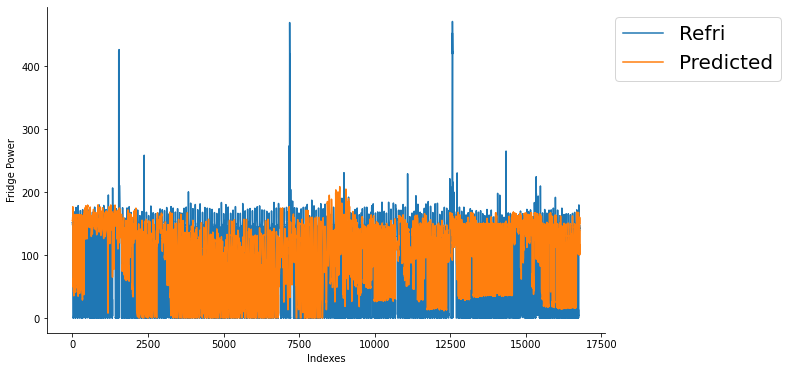

In [41]:
idx = x_test.shape[0]
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test.cpu()[:idx], label = "Refri")
plt.plot(jnp.arange(idx), y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("Indexes")
plt.ylabel("Fridge Power")
sns.despine()
# plt.savefig("gp_ref_full_rbf_per_rbf_actdims.png", bbox_inches="tight")

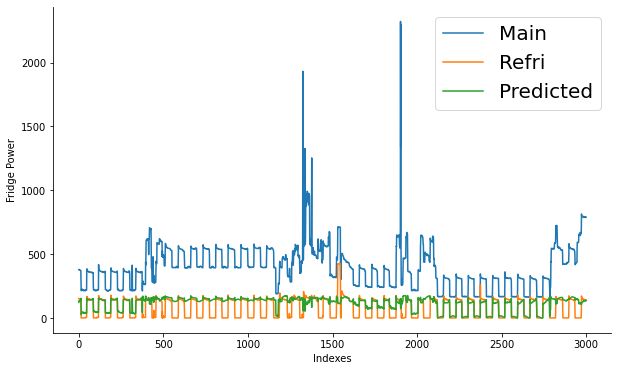

In [21]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), scaler_x.inverse_transform(x_test.cpu().reshape(-1,1))[:idx], label = "Main")
plt.plot(jnp.arange(idx), y_test.cpu()[:idx], label = "Refri")
plt.plot(jnp.arange(idx), y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("Indexes")
plt.ylabel("Fridge Power")
sns.despine()

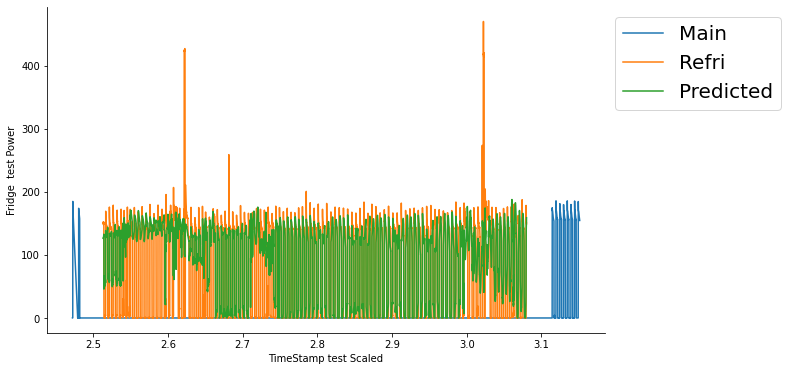

In [64]:
start = 52000
idx = 8000
plt.figure(figsize=(10,6))
plt.plot(x_train_timestamp[start:start+600], scaler_y.inverse_transform(y_train.cpu().reshape(-1,1))[start:start+600], label = "Main")
plt.plot(x_test_timestamp[:idx], y_test.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

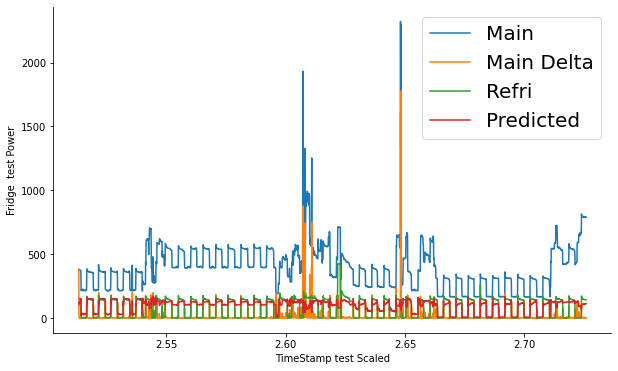

In [21]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], scaler_x.inverse_transform(x_test.cpu().reshape(-1,1))[:idx], label = "Main")
plt.plot(x_test_timestamp[:idx], scaler_delta.inverse_transform(x_test_delta.cpu().reshape(-1,1))[:idx], label = "Main Delta")
plt.plot(x_test_timestamp[:idx], y_test.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

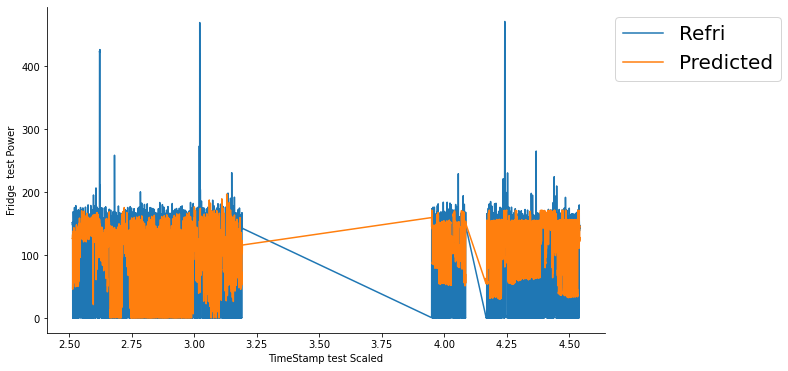

In [36]:
idx = x_test.shape[0]
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], y_test.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

In [ ]:
# y_pred_train_arr =[]
# pred_dist_train = model.predict(x_train_full.to("cuda"))

# y_pred_train_arr.append(pred_dist_train.loc)

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [ ]:
# y_pred_train_arr1 = []
# for i in range(len(y_pred_train_arr)):
#   y_pred_train_arr1.append(np.array(y_pred_train_arr[i].cpu()))

In [ ]:
# y_mean_train = np.mean(y_pred_train_arr1, axis =0)
# y_mean_train = scaler_y.inverse_transform(y_mean_train.reshape(-1,1)).squeeze()
# y_train_trans = scaler_y.inverse_transform(y_train.reshape(-1,1)).squeeze()
# mae_t = np.mean(np.abs(np.array(y_train_trans) - y_mean_train))
# rms_t = errors.rmse(jnp.array(y_train_trans), y_mean_train)

# print("MAE: ", mae_t)
# print("RMSE: ", rms_t)

MAE:  36.75153557017609
RMSE:  55.045277


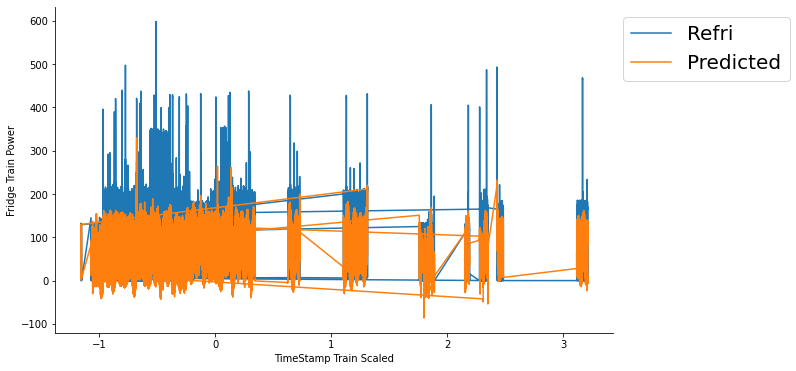

In [ ]:
# idx = x_train.shape[0]
# plt.figure(figsize=(10,6))
# plt.plot(x_train_timestamp, y_train_trans[:idx], label = "Refri")
# plt.plot(x_train_timestamp, y_mean_train[:idx], label = "Predicted")
# plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
# plt.xlabel("TimeStamp Train Scaled")
# plt.ylabel("Fridge Train Power")
# sns.despine()

In [ ]:
# idx = 3000
# plt.figure(figsize=(10,6))
# plt.plot(jnp.arange(idx), y_test.cpu()[:idx], label = "Refrigerator", color="green")
# plt.plot(jnp.arange(idx), y_mean[:idx].reshape(-1,1), label = "Predicted")
# for i in range(1,4):
#     plt.fill_between(jnp.arange(idx), y_mean[:idx] - i*y_sigma[:idx], y_mean[:idx] + i*y_sigma[:idx],
#                     color="orange", alpha=(1/(i*3)), label=f"$\mu\pm{i}*\sigma$")
# plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
# plt.ylabel("Power", fontsize=20)
# sns.despine()
# plt.savefig("gp_ref_full__mattern_per_rbf_actdims.png")

## Decomposition

In [33]:
model1 = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel1,
                      inducing_points).to("cuda")

In [34]:
pred_dist1 = model1.predict(x_test_full[:4000].to("cuda"))
# print("Done ", i)

y_mean1 = pred_dist1.loc

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


In [35]:
pred_arr =[]
pred_arr.append(np.array(pred_dist1.mean.cpu()))

In [36]:
y_mean = np.mean(pred_arr, axis =0)
y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1)).squeeze()

In [37]:
y_mean_ = np.clip(y_mean,0,y_mean.max())

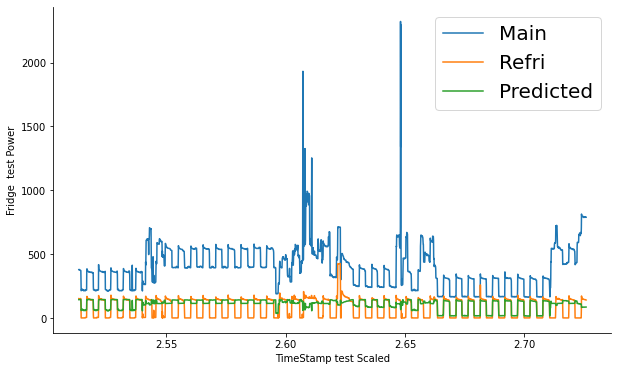

In [38]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], scaler_x.inverse_transform(x_test.cpu().reshape(-1,1))[:idx], label = "Main")
plt.plot(x_test_timestamp[:idx], y_test.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean_[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

In [39]:
model2 = SGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel2*kernel3,
                      inducing_points).to("cuda")

In [40]:
pred_dist2 = model2.predict(x_test_full[:4000].to("cuda"))
# print("Done ", i)

y_mean2 = pred_dist2.loc

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


In [41]:
y_mean = scaler_y.inverse_transform(y_mean2.cpu().reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean.shape)

torch.Size([16781]) (4000,)


In [42]:
y_mean_ = np.clip(y_mean,0,y_mean.max())

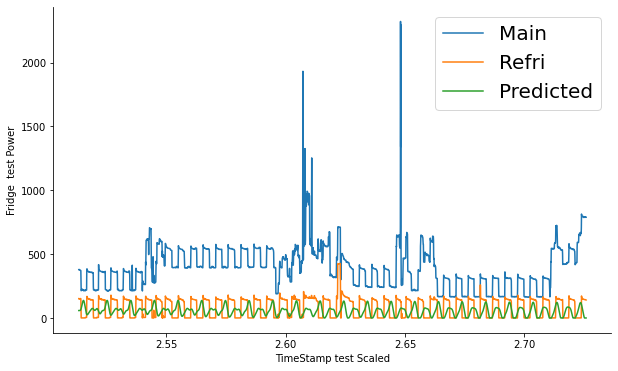

In [43]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], scaler_x.inverse_transform(x_test.cpu().reshape(-1,1))[:idx], label = "Main")
plt.plot(x_test_timestamp[:idx], y_test.cpu()[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean_[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.xlabel("TimeStamp test Scaled")
plt.ylabel("Fridge  test Power")
sns.despine()

### SGDGP

restart: 0, epoch: 1, iter: 1, loss: 1.2204
restart: 0, epoch: 1, iter: 2, loss: 2.4059
restart: 0, epoch: 1, iter: 3, loss: 3.6454
restart: 0, epoch: 1, iter: 4, loss: 4.7996
restart: 0, epoch: 1, iter: 5, loss: 6.0271
restart: 0, epoch: 1, iter: 6, loss: 7.2287
restart: 0, epoch: 1, iter: 7, loss: 8.3947
restart: 0, epoch: 1, iter: 8, loss: 9.5488
restart: 0, epoch: 1, iter: 9, loss: 10.7335
restart: 0, epoch: 1, iter: 10, loss: 11.9549
restart: 0, epoch: 1, iter: 11, loss: 13.1382
restart: 0, epoch: 1, iter: 12, loss: 14.3402
restart: 0, epoch: 1, iter: 13, loss: 15.5456
restart: 0, epoch: 1, iter: 14, loss: 16.7331
restart: 0, epoch: 1, iter: 15, loss: 17.9510
restart: 0, epoch: 1, iter: 16, loss: 19.1770
restart: 0, epoch: 1, iter: 17, loss: 20.3645
restart: 0, epoch: 1, iter: 18, loss: 21.6342
restart: 0, epoch: 1, iter: 19, loss: 22.7832
restart: 0, epoch: 1, iter: 20, loss: 24.0359
restart: 0, epoch: 1, iter: 21, loss: 25.1710
restart: 0, epoch: 1, iter: 22, loss: 26.3517
resta

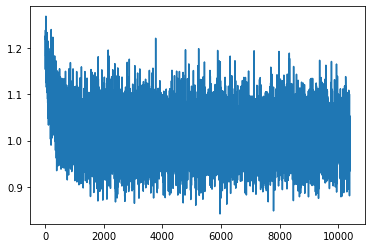

In [ ]:
# mae_arr =[]
# rms_arr = []
# y_pred_arr = []


# # x_train = x_train[:4500]
# # y_train = y_train[:4500]

# # y_test_trans = torch.tensor(torch.tensor(scaler_x.transform(y_test.reshape(-1,1))).reshape(-1,)).contiguous().to(torch.float64)
# for i in range(1):


#   kernel1 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(0))) #nu=2.5,
#   kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(1)))
#   kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(1)))
#   # kernel4 = ScaleKernel(PeriodicKernel(ard_num_dims=2, active_dims=(0)))
#   # kernel5 = ScaleKernel(CosineKernel(ard_num_dims=2, active_dims=(1)))

#   kernel = kernel1 + kernel2*kernel3
#   # induce_points = 512
#   # inducing_points =  x_train_full[np.arange(0,x_train_full.shape[0],100)] 
#   #x_train_full[torch.randperm(x_train_full.shape[0])[: batch]].to("cuda")
  
#   model = ExactGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel).to("cuda")
#   # model.mll.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-2))
#   # for param in model.parameters():
#   #   # print(param)
#   #   torch.nn.init.normal_(param, 0, 1)
#   # theta1 = {'likelihood.noise_covar.noise': torch.tensor(3),
#   #       'covar_module.base_kernel.lengthscale': torch.tensor(0.1),
#   #       'covar_module.outputscale': torch.tensor(5),}
#   loss = model.fit(lr=1e-2, n_epochs=200,verbose=1, batch_size=1024,
#           random_state=0)
# #   loss_arr.append(loss)
#   # print(loss)
#   plt.plot(np.asarray(loss[0]))
#   # plt.plot(np.asarray(test_loss[0]))


  

In [ ]:

# model_name = "Refrigerator_sgdp_trial.pt"
# torch.save(model.state_dict(), os.path.join(
#   "/models/", model_name))


In [ ]:
kernel1 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(0))) #nu=2.5,
kernel2 = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(1)))
kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=2, active_dims=(1)))
# kernel4 = ScaleKernel(PeriodicKernel(ard_num_dims=2, active_dims=(0)))
# kernel5 = ScaleKernel(CosineKernel(ard_num_dims=2, active_dims=(1)))

kernel = kernel1 + kernel2*kernel3
# induce_points = 512
# inducing_points =  x_train_full[np.arange(0,x_train_full.shape[0],100)] 
#x_train_full[torch.randperm(x_train_full.shape[0])[: batch]].to("cuda")

model = ExactGPRegressor(x_train_full.to("cuda"), y_train.to("cuda"), kernel).to("cuda")

In [ ]:

model_name = "Refrigerator_sgdp_trial.pt"
model.load_state_dict(torch.load(
    os.path.join("models/", model_name)))

<All keys matched successfully>

In [ ]:
means,vars = model.predict_batch(x_test_full.cuda(),512,10)


0it [00:00, ?it/s]/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/lazy/lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
33it [00:03, 10.97it/s]


In [ ]:
means = scaler_y.inverse_transform(means.cpu().reshape(-1,1)).squeeze()
rmse = torch.square(torch.subtract(torch.tensor(means),y_test)).mean().item()
print("RMSE:", rmse)

RMSE: 5597.494653027288


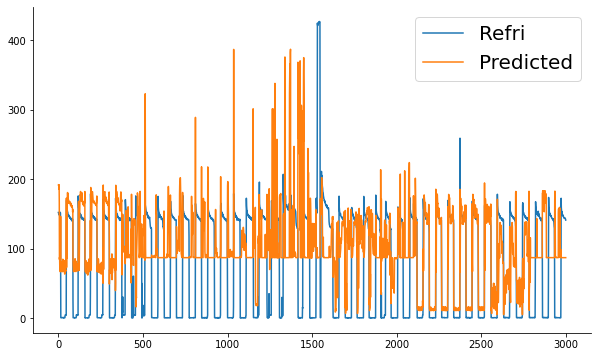

In [ ]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test.cpu()[:idx], label = "Refri")
plt.plot(jnp.arange(idx), means[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
# plt.savefig("gp_ref_full_rbf_per_rbf_actdims.png", bbox_inches="tight")

In [ ]:
y_sigma = scaler_y.inverse_transform(vars.cpu().reshape(-1,1)).squeeze()

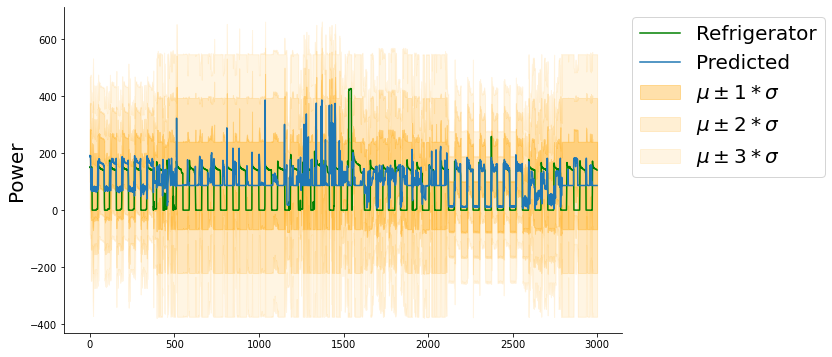

In [ ]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test.cpu()[:idx], label = "Refrigerator", color="green")
plt.plot(jnp.arange(idx), means[:idx].reshape(-1,1), label = "Predicted")
for i in range(1,4):
    plt.fill_between(jnp.arange(idx), means[:idx] - i*y_sigma[:idx], means[:idx] + i*y_sigma[:idx],
                    color="orange", alpha=(1/(i*3)), label=f"$\mu\pm{i}*\sigma$")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.ylabel("Power", fontsize=20)
sns.despine()
# plt.savefig("gp_ref_full__mattern_per_rbf_actdims.png")